## Compare oil type volumes by vessel 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yaml
from monte_carlo_utils import decimal_divide
from monte_carlo_utils import get_oil_classification
from monte_carlo_utils import get_DOE_barges
import monte_carlo_utils
from pathlib import Path

In [2]:
#~~~~~  User inputs ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Dept. of Ecology data files
DOE_dir  = Path('/Users/rmueller/Data/MIDOSS/DeptOfEcology/')
DOE_2018_xlsx = DOE_dir/'MuellerTrans4-30-20.xlsx'
DOE_2021_xlsx = DOE_dir/'MuellerTrans_5-26-21.xlsx'

data_types    = ['total_gallons', 'fraction_of_total', 'number_of_transfers']
# oil types used in our study
oil_types = [
    'ANS','Bunker-C','Diesel','Gasoline','Jet Fuel', 'Dilbit', 'Other'
]
oil_colors = [
    'orange', 'saddlebrown','darkslateblue',
    'steelblue','slateblue','olive',
    'darkgoldenrod'
]
# create a color dictionary for oil types to us in pie charts
colordict={}
for l,c in zip(oil_types,oil_colors):
    colordict[l]=c

# Voyage dataset
CamSheet = '/Users/rmueller/Library/Mobile Documents/com~apple~CloudDocs/Documents/'\
    'Publications/MIDOSS/MIDOSS_MuellerEtAl_paper1/Methods/origin-destination/'\
    'Origin_Destination_Analysis_updated.xlsx'

# 10,000 monte carlo spills
#monte_carlo_csv = '/Users/rmueller/Data/MIDOSS/monte_carlo/SalishSeaOilSpills_fixbarge_10000.csv'
#monte_carlo_csv = '/Users/rmueller/Data/MIDOSS/monte_carlo/SalishSeaSpills_10000_adjustbargecargo.csv'
monte_carlo_csv = '/Users/rmueller/Data/MIDOSS/monte_carlo/SalishSeaOilSpills_fixbarge_10000_1.csv'

# Load Oil Attribution file 
oil_attribution_file = '/Users/rmueller/Data/MIDOSS/marine_transport_data/oil_attribution.yaml'

with open(oil_attribution_file) as file:
        oil_attrs = yaml.load(file, Loader=yaml.Loader)

# location of output excel spreadsheets
output_directory = Path('/Users/rmueller/Data/MIDOSS/DeptOfEcology/')
graphics_directory = Path(
    '/Users/rmueller/Projects/MIDOSS/graphics_figures/monte_carlo'
)

# The precision used to calculate oil type weights 
# Trial and error showed that a precision of 2 is neccessary for weights
# to sum to 1.0
precision = 2

# unit conversions
gal2m3 = 0.00378541

# facility names

# The following list includes facilities used in Casey's origin/destination 
# analysis with names matching the Dept. of Ecology (DOE) database.  
# For example, the shapefile "Maxum Petroleum - Harbor Island Terminal" is 
# labeled as 'Maxum (Rainer Petroleum)' in the DOE database.  I use the 
# Ecology language here and will need to translate to Shapefile speak

# Terminals that are grouped in voyage joins are removed, e.g.:
# 'Maxum (Rainer Petroleum)' and 'Shell Oil LP Seattle Distribution Terminal' 
# are represented in
#  ==>'Kinder Morgan Liquids Terminal - Harbor Island' 
# 'Nustar Energy Tacoma' => 'Phillips 66 Tacoma Terminal'
facility_names = [ 
    'BP Cherry Point Refinery', 'Shell Puget Sound Refinery', 
    'Tidewater Snake River Terminal', 'SeaPort Sound Terminal', 
    'Tesoro Vancouver Terminal', 'Phillips 66 Ferndale Refinery', 
    'Phillips 66 Tacoma Terminal', 
    'Andeavor Anacortes Refinery (formerly Tesoro)',
    'Tesoro Port Angeles Terminal','U.S. Oil & Refining',
    'Naval Air Station Whidbey Island (NASWI)',
    'NAVSUP Manchester', 'Alon Asphalt Company (Paramount Petroleum)', 
    'Kinder Morgan Liquids Terminal - Harbor Island' ,  
    'Tesoro Pasco Terminal', 'REG Grays Harbor, LLC', 
    'Tidewater Vancouver Terminal','TLP Management Services LLC (TMS)'
]

# list of facility names to query monte-carlo csv file, with:
# 1) Marathon Anacortes Refinery (formerly Tesoro) instead of Andeavor 
#    Anacortes Refinery (formerly Tesoro) 
# 2) Maxum Petroleum - Harbor Island Terminal instead of 
#    Maxum (Rainer Petroleum)
facility_names_mc = [ 
    'BP Cherry Point Refinery', 'Shell Puget Sound Refinery',
    'Tidewater Snake River Terminal', 
    'SeaPort Sound Terminal', 'Tesoro Vancouver Terminal',
    'Phillips 66 Ferndale Refinery', 'Phillips 66 Tacoma Terminal', 
    'Marathon Anacortes Refinery (formerly Tesoro)',
    'Tesoro Port Angeles Terminal','U.S. Oil & Refining',
    'Naval Air Station Whidbey Island (NASWI)',
    'NAVSUP Manchester', 'Alon Asphalt Company (Paramount Petroleum)', 
    'Kinder Morgan Liquids Terminal - Harbor Island',
    'Tesoro Pasco Terminal', 'REG Grays Harbor, LLC', 
    'Tidewater Vancouver Terminal',
    'TLP Management Services LLC (TMS)'
]

---
## Plot monte carlo representation of oil typetransport by barge
---

In [5]:
import pandas
def get_montecarlo_oilexport(vessel, monte_carlo_csv):
    # open montecarlo spills file
    mcdf = pandas.read_csv(monte_carlo_csv)
    # replace Lagrangian template with oil type tags
    mcdf['Lagrangian_template'] = mcdf['Lagrangian_template'].replace(
        ['Lagrangian_akns.dat','Lagrangian_bunker.dat',
         'Lagrangian_diesel.dat','Lagrangian_gas.dat',
         'Lagrangian_jet.dat','Lagrangian_dilbit.dat',
         'Lagrangian_other.dat'], 
        ['ANS','Bunker-C','Diesel','Gasoline','Jet Fuel', 'Dilbit', 
         'Other']
    )
     # query dataframe for infromation on oil export types by vessel
    spill_capacity[vessel] = mcdf.loc[
        (mcdf.vessel_type == vessel) &
        (mcdf.fuel_cargo == 'cargo') &
        ((mcdf.vessel_origin == 'US') | 
         (mcdf.vessel_origin.isin(facility_names_mc))),
        ['cargo_capacity', 'vessel_origin', 'Lagrangian_template']
    ]
    # add up oil capacities by vessel and oil types
    total_capacity = (
        spill_capacity[vessel].groupby(
            'Lagrangian_template'
        ).cargo_capacity.sum()
    )
    return total_capacity

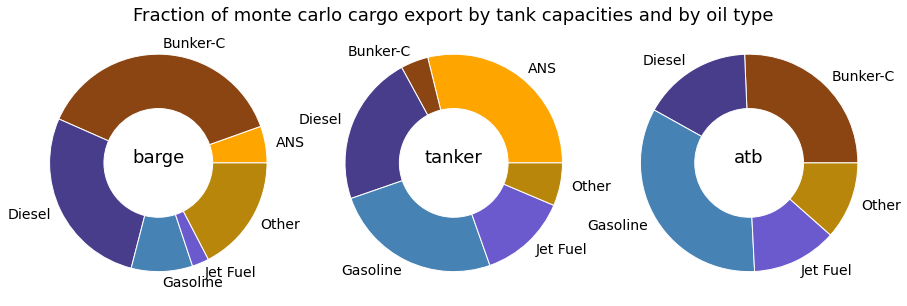

In [6]:
# Get cargo exports by vessel type and add up cargo_capacities by oil type
spill_capacity = {}
       
fig, axes = plt.subplots(1, 3, figsize = (15,5))
for idx,vessel in enumerate(["barge","tanker","atb"]):
    # calculate total cargo_capacity by vessel type and oil type
    total_capacity = get_montecarlo_oilexport(
        vessel, 
        monte_carlo_csv
    )
    # add central title
    axes[idx].axis('equal') 
    if idx==1:
        axes[idx].set_title(
            f'Fraction of monte carlo cargo export by tank capacities and by oil type',
            fontsize=18
        )
    # plot up results
    pie_wedge_collection  = axes[idx].pie(
        total_capacity, 
        labels = total_capacity.index.to_list(),
        wedgeprops=dict(width=0.5),
        textprops={'fontsize': 14}
    )
    # make colors uniform across subplots
    for pie_wedge in pie_wedge_collection[0]:
        pie_wedge.set_edgecolor('white')
        pie_wedge.set_facecolor(colordict[pie_wedge.get_label()])
        
    axes[idx].axis('off')
    axes[idx].text(0,0,vessel,ha='center',fontsize=18)
plt.savefig(graphics_directory/'monte_carlo_oil_exports')